In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.arange(0, 100).view(10, 10)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [3]:
# These are indicies into a discrete structure with 4 values.

X = torch.arange(0, 2) * 2 + torch.arange(0, 2).unsqueeze(1) 
X

tensor([[0, 2],
        [1, 3]])

In [4]:
# Suppose these are the 4 embeddings, each as row vectors.
C = torch.tensor([[1, 11], [2, 12], [3, 13], [4, 14]])
print(C)

# we can basically use the structure of X and index into C.
# For each index in C, we can replace the index with the value in C at the index.
C[X]

tensor([[ 1, 11],
        [ 2, 12],
        [ 3, 13],
        [ 4, 14]])


tensor([[[ 1, 11],
         [ 3, 13]],

        [[ 2, 12],
         [ 4, 14]]])

In [5]:
# Now we can flatten the structure: "unbind" the embedding dimension and concatenate them
print(torch.unbind(C[X], 1))
torch.cat(torch.unbind(C[X], 1), 1)

(tensor([[ 1, 11],
        [ 2, 12]]), tensor([[ 3, 13],
        [ 4, 14]]))


tensor([[ 1, 11,  3, 13],
        [ 2, 12,  4, 14]])

In [6]:
# Now we can flatten the structure: "unbind" the embedding dimension and concatenate them
C[X].view(-1, 4)

tensor([[ 1, 11,  3, 13],
        [ 2, 12,  4, 14]])

Idea: every token corresponds to an n dimensional embedding
> "Fighting the curse of dimensionality with distributed representations"

Because tokens/words are embedded a shared high dimensional space, this allows "smoothing" for inputs out of distribution, aka combinations never encountered before.
Similar inputs will result in more similar outputs.

> "learned distributed feature vector"



With n-gram models, context scales exponentially. Base: # of tokens. Exponent: length of context. So we never go beyond bigram/trigram.
With MLP, context scales linearly. 

bengio et all used a 30-dimensional embedding for 17k words
karpathy used a 2 dimensional embedding for 27 tokens (26 + start/end token).

in the previous network we simply indexed into a single 27*27 matrix that when multiplied produced next token probabilties.

now we translate characters aka indicies into embeddings.

27*n matrix of indicies


- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2


In [7]:
# read in all the words
words = open('makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Reinit here!


In [10]:
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y



Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [11]:
Xtr[:10]

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 25],
        [ 0,  0,  0, 25, 21],
        [ 0,  0, 25, 21,  8],
        [ 0, 25, 21,  8,  5],
        [25, 21,  8,  5, 14],
        [21,  8,  5, 14,  7],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  4],
        [ 0,  0,  0,  4,  9]])

In [12]:
W1_n = 200
t_d = 12
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, t_d), generator=g)
W1 = torch.randn((t_d * block_size, W1_n), generator=g)
# W1 = torch.ones((t_d * block_size, W1_n))
b1 = torch.randn(W1_n, generator=g)
# b1 = torch.zeros(W1_n)
# W2 = torch.randn((W1_n, 27), generator=g)
W2 = torch.ones((W1_n, 27))/27
# b2 = torch.randn(27, generator=g)
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]

In [13]:
sum(p.nelement() for p in parameters) # number of parameters in total


17951

In [14]:
for p in parameters:
  p.requires_grad = True

In [15]:
# learning-rate exponent
lre = torch.linspace(-3, 0, 1000)

# learing-rate step
lrs = 10**lre

In [16]:
lri = []
lossi = []
stepi = []

In [17]:
Xtr.shape[0]

182625

In [18]:
# Batch indicies
ix = torch.randint(0, Xtr.shape[0], (32,))
ix

tensor([179967, 134752, 160976, 115412,  36183,  20124,  31946, 103236,  41975,
          1598,  12820,  28838,   5937,   1275, 180886, 143792,   3302, 143438,
         60735,  38399,  70847, 179673,  41997, 137215, 148277, 118246,  40810,
         38617,  80583, 176565, 169556,  79113])

In [19]:
# Get context from indicies
Xtr[ix][:10]

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0, 11, 15,  2],
        [ 0,  0,  0,  0, 12],
        [13,  1, 12,  5,  9],
        [ 0,  0,  0,  0,  0],
        [18, 15,  3,  3, 15],
        [ 9,  5, 12, 12,  5],
        [ 0,  0, 10, 15, 18],
        [ 0,  3,  8,  1, 25],
        [ 0,  0, 26,  1, 18]])

In [20]:
for i in range(400000):
  
  # minibatch construct
  # Take 32 random sequences from training set.
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass

  # Xtr[ix] adds context ("get context at list index ix"). ix is list of sample indicies.
  # C[Xtr[ix]] adds embedding ("get embedding at token index xtr"). Xtr[ix] is list of token indicies.

  emb = C[Xtr[ix]] # (32, 3, 10)

  # emb.view: We collapse the embedding tensor dimension
  # and get a (32, 30) tensor

  # 32 items in "30 dimensional space"

  # which we multiply by weights W1 (30, 200) (30 rows, 200 columns)
  # to get a (32, 200) tensor
  h = torch.tanh(emb.view(-1, t_d * block_size) @ W1 + b1) # (32, 200)

  # Idea:
  # We're lifing up the 32 items to "200 dimensional space"

  # And then We multiply by W2 (200, 27) to get prediction back.
  # Idea: we project back down to "27-dimensional space".
  # These two determine a "probability function" for these 30-dimensional token embeddings (which we're simultaneously learning).
  logits = h @ W2 + b2 # (32, 27)

  # Finally we compute probabilities and see how well that models the output data
  # log it, and invert it.
  loss = F.cross_entropy(logits, Ytr[ix], label_smoothing=0.00) 

  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  lr = lr  if i < 200000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  # lossi.append(loss.log10().item())
  lossi.append(loss.log10().item())

#print(loss.item())


In [21]:
import numpy as np
np.power(10, lossi[0])

3.295837068753555

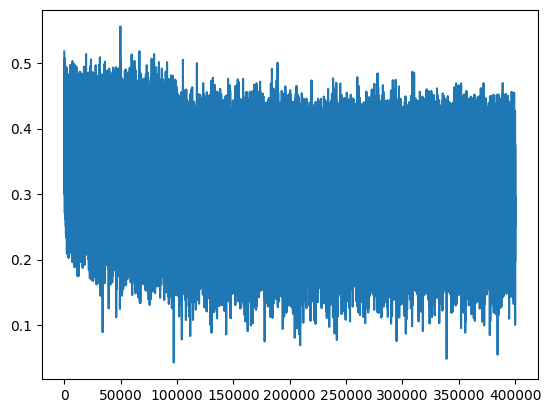

In [22]:
plt.plot(stepi, lossi)


```
default:
block_size: 3
t_d: 10
W1_n: 200

default:                      | loss_tr = 2.1146, loss_va = 2.1766, diff ~= .06
default:                      | loss_tr = 2.1171, loss_va = 2.1602, diff ~= .04

block_size: 5                 | loss_tr = 2.1945, loss_va = 2.2241, diff ~= .03
t_d: 11                       | loss_tr = 2.1093, loss_va = 2.1637, diff ~= .05
t_d: 12                       | loss_tr = 2.1064, loss_va = 2.1575, diff ~= .05
t_d: 12                       | loss_tr = 2.1047, loss_va = 2.1581, diff ~= .05
t_d: 12 +  W1_n: 205          | 
t_d: 15                       | loss_tr = 2.0893, loss_va = 2.1709, diff ~= .08
t_d: 20                       | loss_tr = 2.0680, loss_va = 2.1646, diff ~= .1
t_d: 20 + 0.1 smoothing       | loss_tr = 2.1085, loss_va = 2.1668, diff ~= .06
default + 0.1 smoothing       | loss_tr = 2.1890, loss_va = 2.2265, diff ~= .04
default + 0.01 smoothing      | loss_tr = 2.1252, loss_va = 2.1766, diff ~= .05
W1_n: 400 + 0.01 smoothing    | loss_tr = 2.1061, loss_va = 2.2481, diff ~= .15
W1_n: 1000                    | loss_tr = 2.1061, loss_va = 2.2481, diff ~= .15
```


In [23]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, t_d*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0118, grad_fn=<NllLossBackward0>)

In [24]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, t_d*block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1091, grad_fn=<NllLossBackward0>)

E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

suppose probabilities are uniform -- 1/27 for all
then likelihood given any outcome is uniform -- 1/27 for all
then negative log likelyhood given any outcome is uniform -- -log(1/27)

expected initial loss: 3.295836866004329

We should also set bias to zero.


2.13   | block_size: 3, t_d: 12
2.1143 | block_size: 4, t_d: 12
2.1133 | block_size: 5, t_d: 12
2.1188 | block_size: 5, t_d: 12
2.1124 | block_size: 5, t_d: 12

okay what if we do the same with the first layer?

In [25]:
# Exercise: derive generate code

def gen_word():
    context = [0] * block_size
    while True:
      emb = C[context[-block_size:]] # (1, 3, 2)
      h = torch.tanh(emb.view(-1, t_d*block_size) @ W1 + b1) # (block_size, 100)
      logits = h @ W2 + b2 # (32, 27)
      # get probabilities
      probs = torch.softmax(logits, dim=1)
      iy = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
      if iy.item() == 0:
        break
      context = context + [iy.item()] # crop and append
    word = []
    for c in context[block_size:]:
      word.append(itos[c])
    return "".join(word)

for _ in range(500):
  print(gen_word())

gwaleaya
keantosere
brittaberer
colline
jaylou
vaiz
jaleeza
taria
zayleee
marcey
anulisa
kanderlie
lerix
elona
brianna
khise
abubagr
pyleeus
sofania
win
graye
aneya
olaini
axi
zamius
granna
kalay
maura
delon
syldyna
latdin
junika
pennie
aeri
zemari
ysan
roelen
saizlen
ramariulo
wigsola
amela
xavel
savan
manairah
terron
stami
srigona
reina
ariad
brita
eslin
melk
azielleigh
dunc
esmorel
andrer
relyun
cacia
malei
tahmiel
brene
haranna
haver
sempo
slapnt
jevon
penia
ariby
vickonalia
merorynn
joiis
innas
perna
aryan
aaklyn
brayee
lligre
kaylee
moa
hazanelly
roniw
kazyah
brerdy
emrina
elian
gakses
avrie
lavis
mark
leina
oxany
daliree
ranusha
kaie
nak
maudi
brynllie
jenot
jaclynn
zamir
kymia
airinno
seon
corbella
olarie
milael
brancelo
darytan
ramynn
kinzeen
kayloi
desys
synca
lean
jayler
aelynnetlin
slyshi
janyela
rexsee
lanley
lijeerat
domerie
merkovios
yamlen
terfle
jayah
zoriel
shenid
caran
mata
madion
rasee
phlaush
fanysh
amin
lyian
amaza
marely
azoel
idarah
bocttie
suriah
oshon
norten
c

In [26]:
import numpy as np
-1 * np.log(1/27)

3.295836866004329

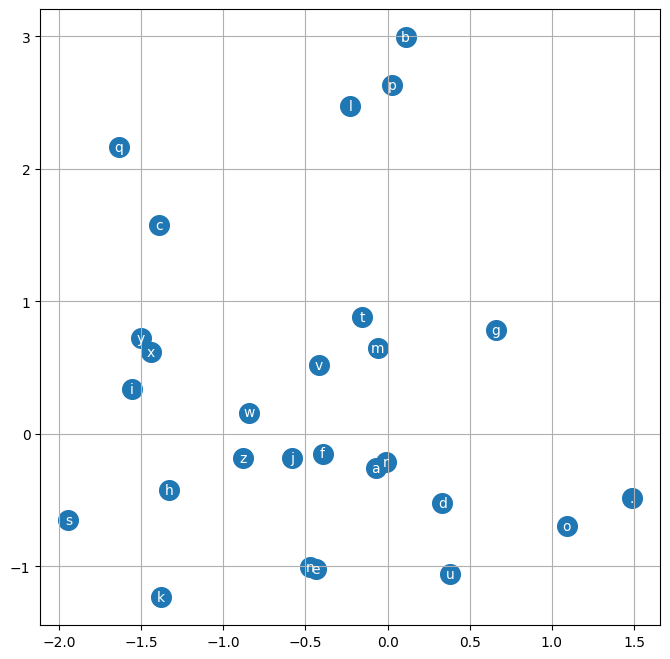

In [27]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

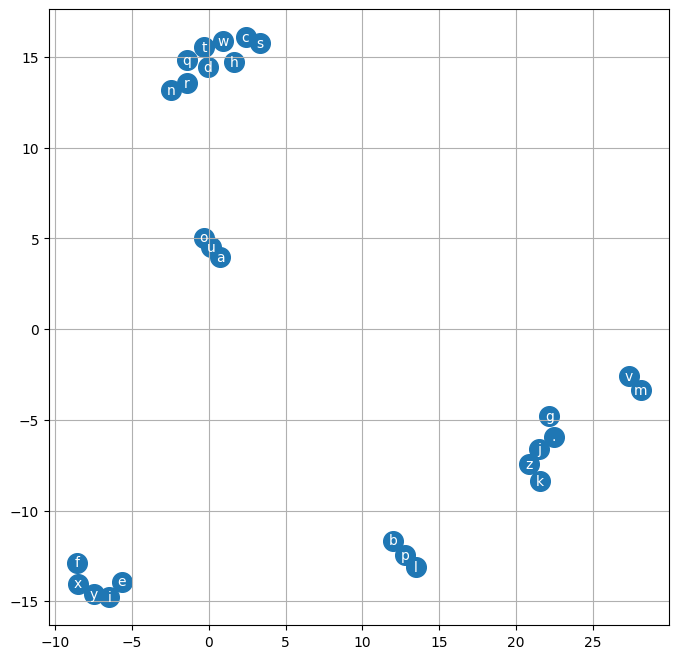

In [57]:
import umap
# visualize umapped embedding matrix C for all characters

C_r = umap.UMAP(n_components=2, n_neighbors=2, min_dist=1, metric="cosine").fit_transform(C.detach().numpy())


plt.figure(figsize=(8,8))
plt.scatter(C_r[:,0].data, C_r[:,1].data, s=200)
for i in range(C_r.shape[0]):
    plt.text(C_r[i,0].item(), C_r[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')